In [3]:
import pandas as pd
from codebleu.codebleu import calc_codebleu
import re
import numpy as np
from tqdm.auto import tqdm
import pickle

from transformers import AutoTokenizer, AutoModelForCausalLM

In [4]:
df_vanilla = pd.read_json('inference_output_11_models_vre_extended.json', orient='records', lines=True).sort_values(by=["sample_id", "model_path", "source_language", "target_language"]).reset_index()
df_control = pd.read_json('inference_output_11_models_cre_extended.json', orient='records', lines=True).sort_values(by=["sample_id", "model_path", "source_language", "target_language"]).reset_index()

In [5]:
df_control = df_control[~df_control.apply(lambda row: row.astype(str).str.contains('Mixtral').any(), axis=1)]
df_vanilla = df_vanilla[~df_vanilla.apply(lambda row: row.astype(str).str.contains('Mixtral').any(), axis=1)]

In [6]:
df_control.shape

(36570, 20)

In [7]:
df_vanilla.shape

(36570, 20)

In [8]:
def extract_source_code(text):
    pattern = re.compile(r'Response:?.*?```(?:java|cpp|csharp|python|c|go|C\+\+|Java|Python|C#|C|Go)?\s*(.+?)\s*```', re.DOTALL)
    match = pattern.search(text)
    if match:
        return match.group(1).strip()
    #Empty string is returned instead of None
    return None

In [9]:
def extract_outputs_regex(df):
    extracted_outputs = []
    matched_count = 0

    for index, row in df.iterrows():
        extracted = extract_source_code(row['prompt_template'] + row['new_tokens_from_inference_output'])
        if extracted:
            matched_count+=1
            extracted_outputs.append(extracted)
        else:
            #extracted_outputs.append("")
            extracted_outputs.append(np.nan)

    return extracted_outputs, (matched_count / df.shape[0]) * 100

In [10]:
vre_extracted, msr_vre = extract_outputs_regex(df_vanilla)
cre_extracted, msr_cre = extract_outputs_regex(df_control)

df_vre = df_vanilla.copy()
df_vde = df_vanilla.copy()
df_cre = df_control.copy()
df_cde = df_control.copy()

df_vre['proc_inference_output'] = vre_extracted
df_vde['proc_inference_output'] = df_vanilla['new_tokens_from_inference_output']

df_cre['proc_inference_output'] = cre_extracted
df_cde['proc_inference_output'] = df_control['new_tokens_from_inference_output']

In [11]:
len(df_vre)

36570

In [12]:
len(df_cre)

36570

In [13]:
#FIXME: These numbers don't match the paper? Need to figure out why
print(f'MSR VRE: {msr_vre}')
print(f'MSR CRE: {msr_cre}')

MSR VRE: 49.77030352748154
MSR CRE: 96.80612523926716


In [14]:
df_vre.isna().sum()

index                                   0
sample_id                               0
translation_output_id                   0
input_code                              0
prompt_template                         0
new_tokens_from_inference_output        0
test_case_input_data                    0
test_case_expected_output               0
target_language                         0
source_language                         0
model_path                              0
name                                    0
size_in_billions                        0
input_code_hash                         0
problem_id                              0
Python_gt                               0
Java_gt                                 0
C++_gt                                  0
Go_gt                                   0
C_gt                                    0
proc_inference_output               18369
dtype: int64

In [15]:
df_cre.isna().sum()

index                                  0
sample_id                              0
translation_output_id                  0
input_code                             0
prompt_template                        0
new_tokens_from_inference_output       0
test_case_input_data                   0
test_case_expected_output              0
target_language                        0
source_language                        0
model_path                             0
name                                   0
size_in_billions                       0
input_code_hash                        0
problem_id                             0
Python_gt                              0
Java_gt                                0
C++_gt                                 0
Go_gt                                  0
C_gt                                   0
proc_inference_output               1168
dtype: int64

In [16]:
print(df_vre.shape)

(36570, 21)


In [17]:
print(df_cre.shape)

(36570, 21)


In [18]:
df_vre_filtered = df_vre.dropna(subset=['proc_inference_output'])
df_vde_filtered = df_vde[df_vde.index.isin(df_vre_filtered.index)]


df_cre_filtered = df_cre.dropna(subset=['proc_inference_output'])
df_cde_filtered = df_cde[df_cde.index.isin(df_cre_filtered.index)]


In [19]:
print(df_vre_filtered.shape)

(18201, 21)


In [20]:
print(df_cre_filtered.shape)

(35402, 21)


In [22]:
import argparse
import xlcostcb.bleu as bleu
import xlcostcb.weighted_ngram_match as weighted_ngram_match
import xlcostcb.syntax_match as syntax_match
import xlcostcb.dataflow_match as dataflow_match
import argparse

def calc_codebleu_xlcost(refs, hyps, lang):
    alpha,beta,gamma,theta = 0.25, 0.25, 0.25, 0.25

    # preprocess inputs
    pre_references = [[x.strip() for x in ref] if isinstance(ref, list) else [ref.strip()] for ref in refs]
    hypothesis = [x.strip() for x in hyps]
    
    assert len(pre_references) == len(hypothesis)

    references = []
    for i in range(len(hypothesis)):
        ref_for_instance = []
        for j in range(len(pre_references)):
            ref_for_instance.append(pre_references[j][i])
        references.append(ref_for_instance)
    assert len(references) == len(pre_references)*len(hypothesis)


    # calculate ngram match (BLEU)
    tokenized_hyps = [x.split() for x in hypothesis]
    tokenized_refs = [[x.split() for x in reference] for reference in references]

    ngram_match_score = bleu.corpus_bleu(tokenized_refs,tokenized_hyps)

    # calculate weighted ngram match
    # from os import listdir
    # from os.path import isfile, join
    # onlyfiles = [f for f in listdir("./keywords") if isfile(join("keywords", f))]
    # print(onlyfiles)
    keywords = [x.strip() for x in open('xlcostcb/keywords/'+lang+'.txt', 'r', encoding='utf-8').readlines()]

    def make_weights(reference_tokens, key_word_list):
        return {token:1 if token in key_word_list else 0.2 \
                for token in reference_tokens}

    tokenized_refs_with_weights = [[[reference_tokens, make_weights(reference_tokens, keywords)]\
                for reference_tokens in reference] for reference in tokenized_refs]

    weighted_ngram_match_score = weighted_ngram_match.corpus_bleu(tokenized_refs_with_weights,tokenized_hyps)

    # calculate syntax match
    syntax_match_score = syntax_match.corpus_syntax_match(references, hypothesis, lang)

    # calculate dataflow match
    dataflow_match_score = dataflow_match.corpus_dataflow_match(references, hypothesis, lang)

    code_bleu_score = alpha*ngram_match_score\
                    + beta*weighted_ngram_match_score\
                    + gamma*syntax_match_score\
                    + theta*dataflow_match_score

    result = {}
    result['ngram_match_score'] = ngram_match_score
    result['weighted_ngram_match_score'] = weighted_ngram_match_score
    result['syntax_match_score'] = syntax_match_score
    result['dataflow_match_score'] = dataflow_match_score
    result['codebleu'] = code_bleu_score
    return result

In [23]:
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd

def progress_wrapper(model_name, row):
    result = process_row(model_name, row)
    return result

def process_row(model_name, row):
    map_codebleu = {
        'C': 'c',
        'C++': 'cpp',
        'Java': 'java',
        'Go': 'go',
        'Python': 'python'
    }

    lang = row['target_language']
    predicted = row['proc_inference_output']
    references = row[f'{lang}_gt']
    result = calc_codebleu_xlcost([references], [predicted], map_codebleu[lang])

    results = {
        'model': model_name,
        'lang': lang,
        'index': row['index'],
        'code_bleu': float(result['codebleu']),
        'ngram_match_score': result['ngram_match_score'],
        'weighted_ngram_match_score': result['weighted_ngram_match_score'],
        'syntax_match_score': result['syntax_match_score'],
        'dataflow_match_score': result['dataflow_match_score']
    }
    return results

def per_model_codebleu(df):
    model_group = df.groupby("name")

    # Flatten the grouped DataFrame into a list of tuples
    tasks = [(model_name, row) for model_name, model_rows in model_group for _, row in model_rows.iterrows()]

    all_results = []
    with tqdm(total=len(tasks), desc='Processing rows') as pbar:
        # Use joblib.Parallel to process rows in parallel
        all_results = Parallel(n_jobs=-1, backend='multiprocessing')(
            delayed(progress_wrapper)(model_name, row) for model_name, row in tasks
        )
        pbar.update(len(all_results))

    return all_results

In [24]:
def save_to_pickle(data, filename):
    """Save the dictionary to a pickle file."""
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

In [25]:
def read_from_pickle(filename):
    """Read data from a pickle file."""
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

In [26]:
enable_process = False

In [27]:
if enable_process:
    vde_results = per_model_codebleu(df_vde_filtered)

In [28]:
if enable_process:
    vre_results = per_model_codebleu(df_vre_filtered)

In [29]:
if enable_process:
    cre_results = per_model_codebleu(df_cre_filtered)

In [30]:
if enable_process:
    cde_results = per_model_codebleu(df_cde_filtered)

In [31]:
if enable_process:
    save_to_pickle(vre_results, 'vre_results.pkl')

In [32]:
if enable_process:
    save_to_pickle(vde_results, 'vde_results.pkl')

In [33]:
if enable_process:
    save_to_pickle(cre_results, 'cre_results.pkl')

In [34]:
if enable_process:
    save_to_pickle(cde_results, 'cde_results.pkl')

In [35]:
# vre_results = read_from_pickle('vre_codebleu_sentence_noextract_full_2.pkl')
# vde_results = read_from_pickle('vde_codebleu_sentence_noextract_full_2.pkl')
# cre_results = read_from_pickle('cre_codebleu_sentence_noextract_full_2.pkl')

vre_results = read_from_pickle('vre_results.pkl')
vde_results = read_from_pickle('vde_results.pkl')
cre_results = read_from_pickle('cre_results.pkl')
cde_results = read_from_pickle('cde_results.pkl')

In [36]:
df_vre_results = pd.DataFrame(vre_results).reset_index()
df_vde_results = pd.DataFrame(vde_results).reset_index()
df_cre_results = pd.DataFrame(cre_results).reset_index()
df_cde_results = pd.DataFrame(cde_results).reset_index()

In [37]:
df_vre_results_original = pd.DataFrame(vre_results).reset_index()
df_vde_results_original = pd.DataFrame(vde_results).reset_index()
df_cre_results_original = pd.DataFrame(cre_results).reset_index()
df_cde_results_original = pd.DataFrame(cde_results).reset_index()

In [38]:
def filter_by_iqr(df1, df2, column):
    """
    Filters rows of two DataFrames based on the IQR of the percentage change in a specified column.

    Parameters:
    df1 (pd.DataFrame): The first DataFrame.
    df2 (pd.DataFrame): The second DataFrame.
    column (str): The column name on which to calculate the percentage change and filter by IQR.

    Returns:
    pd.DataFrame, pd.DataFrame: The filtered DataFrames.
    """
    # Calculate the change in the specified column
    changes = (df1[column] - df2[column]) / df2[column] * 100

    # Compute the IQR
    # Q1 = changes.quantile(0.25)
    # Q3 = changes.quantile(0.75)
    # IQR = Q3 - Q1

    lower_bound = changes.quantile(0.05) 
    upper_bound = changes.quantile(0.95)
    print(lower_bound)
    print(upper_bound)

    # Define the lower and upper bounds for outliers
    # lower_bound = Q1 - 10 * IQR
    # upper_bound = Q3 + 10 * IQR

    # Filter the rows where the change falls within the IQR
    #filtered_indices = changes[(changes >= lower_bound) & (changes <= upper_bound)].index
    filtered_indices = changes.index

    # Create new DataFrames with the filtered rows
    df1_filtered = df1.loc[filtered_indices]
    df2_filtered = df2.loc[filtered_indices]

    assert len(df1_filtered) == len(df2_filtered)

    return df1_filtered, df2_filtered

In [39]:
df_cre_results.shape

(35402, 9)

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

def count_improvements_results(df1, df2):
    improv_ngram = 0
    improve_cb = 0
    improve_dataflow = 0
    improve_weighted_ngram = 0
    improve_syntax = 0

    less_ngram = 0
    less_cb = 0
    less_dataflow = 0
    less_weighted_ngram = 0
    less_syntax = 0

    same_ngram = 0
    same_cb = 0
    same_dataflow = 0
    same_weighted_ngram = 0
    same_syntax = 0

    # Lists to keep track of row indices
    indices_improv_ngram = []
    indices_improve_cb = []
    indices_improve_dataflow = []
    indices_improve_weighted_ngram = []
    indices_improve_syntax = []

    indices_less_ngram = []
    indices_less_cb = []
    indices_less_dataflow = []
    indices_less_weighted_ngram = []
    indices_less_syntax = []

    indices_same_ngram = []
    indices_same_cb = []
    indices_same_dataflow = []
    indices_same_weighted_ngram = []
    indices_same_syntax = []

    for index, row in df1.iterrows():
        other = df2[df2['index'] == row["index"]].iloc[0]

        if row['code_bleu'] > other['code_bleu']:
            improve_cb += 1
            indices_improve_cb.append(index)
        elif row['code_bleu'] < other['code_bleu']:
            less_cb += 1
            indices_less_cb.append(index)
        else:
            same_cb += 1
            indices_same_cb.append(index)

        if row['ngram_match_score'] > other['ngram_match_score']:
            improv_ngram += 1
            indices_improv_ngram.append(index)
        elif row['ngram_match_score'] < other['ngram_match_score']:
            less_ngram += 1
            indices_less_ngram.append(index)
        else:
            same_ngram += 1
            indices_same_ngram.append(index)

        if row['weighted_ngram_match_score'] > other['weighted_ngram_match_score']:
            improve_weighted_ngram += 1
            indices_improve_weighted_ngram.append(index)
        elif row['weighted_ngram_match_score'] < other['weighted_ngram_match_score']:
            less_weighted_ngram += 1
            indices_less_weighted_ngram.append(index)
        else:
            same_weighted_ngram += 1
            indices_same_weighted_ngram.append(index)

        if row['syntax_match_score'] > other['syntax_match_score']:
            improve_syntax += 1
            indices_improve_syntax.append(index)
        elif row['syntax_match_score'] < other['syntax_match_score']:
            less_syntax += 1
            indices_less_syntax.append(index)
        else:
            same_syntax += 1
            indices_same_syntax.append(index)

        if row['dataflow_match_score'] > other['dataflow_match_score']:
            improve_dataflow += 1
            indices_improve_dataflow.append(index)
        elif row['dataflow_match_score'] < other['dataflow_match_score']:
            less_dataflow += 1
            indices_less_dataflow.append(index)
        else:
            same_dataflow += 1
            indices_same_dataflow.append(index)

    total = len(df1)

    tot_ngram = improv_ngram / total * 100
    tot_cb = improve_cb / total * 100
    tot_df = improve_dataflow / total * 100
    tot_weighted = improve_weighted_ngram / total * 100
    tot_syn = improve_syntax / total * 100

    tot_less_ngram = less_ngram / total * 100
    tot_less_cb = less_cb / total * 100
    tot_less_df = less_dataflow / total * 100
    tot_less_weighted = less_weighted_ngram / total * 100
    tot_less_syn = less_syntax / total * 100

    tot_same_ngram = same_ngram / total * 100
    tot_same_cb = same_cb / total * 100
    tot_same_df = same_dataflow / total * 100
    tot_same_weighted = same_weighted_ngram / total * 100
    tot_same_syn = same_syntax / total * 100

    return {
        'code_bleu': [tot_cb, tot_same_cb, tot_less_cb],
        'ngram_match_score': [tot_ngram, tot_same_ngram, tot_less_ngram],
        'weighted_ngram_match_score': [tot_weighted, tot_same_weighted, tot_less_weighted],
        'syntax_match_score': [tot_syn, tot_same_syn, tot_less_syn],
        'dataflow_match_score': [tot_df, tot_same_df, tot_less_df],
        'indices': {
            'improve_cb': indices_improve_cb,
            'less_cb': indices_less_cb,
            'same_cb': indices_same_cb,
            'improv_ngram': indices_improv_ngram,
            'less_ngram': indices_less_ngram,
            'same_ngram': indices_same_ngram,
            'improve_weighted_ngram': indices_improve_weighted_ngram,
            'less_weighted_ngram': indices_less_weighted_ngram,
            'same_weighted_ngram': indices_same_weighted_ngram,
            'improve_syntax': indices_improve_syntax,
            'less_syntax': indices_less_syntax,
            'same_syntax': indices_same_syntax,
            'improve_dataflow': indices_improve_dataflow,
            'less_dataflow': indices_less_dataflow,
            'same_dataflow': indices_same_dataflow
        }
    }

In [41]:
results_vanilla = count_improvements_results(df_vre_results, df_vde_results)

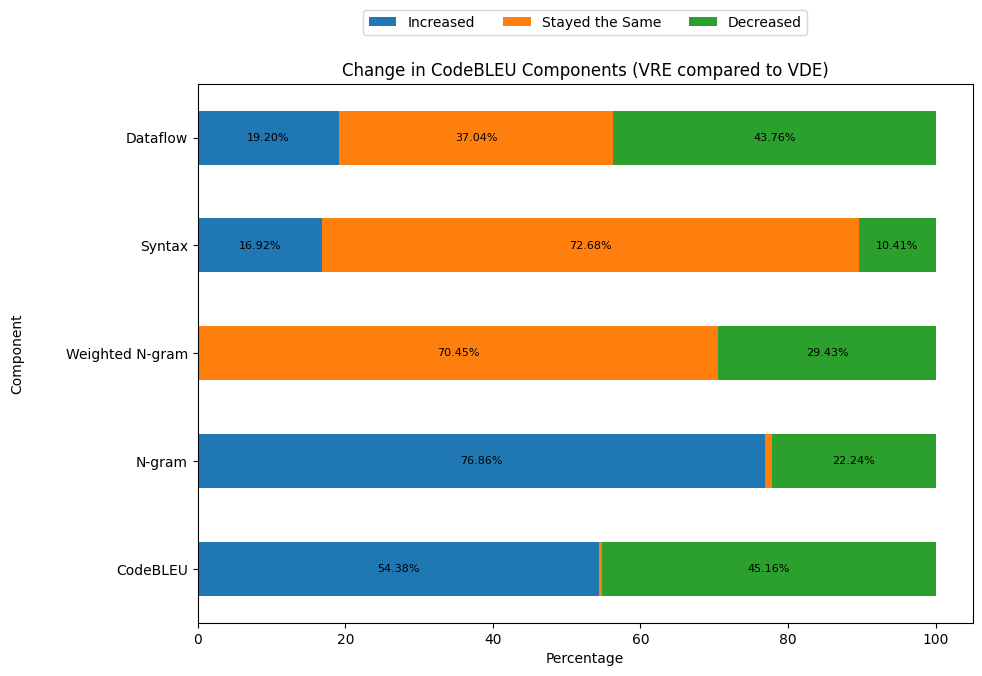

In [101]:
# Create a DataFrame for the results
df_results = pd.DataFrame(results_vanilla, index=['Increased', 'Stayed the Same', 'Decreased']).drop(columns=['indices'])
df_results_copy = df_results.copy()

df_results_copy.columns = ['CodeBLEU', 'N-gram', 'Weighted N-gram', 'Syntax', 'Dataflow']

# Transpose the DataFrame
df_results_copy = df_results_copy.T

# Plot the results
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the DataFrame as a horizontal bar chart
bars = df_results_copy.plot(kind='barh', stacked=True, ax=ax)

# Add labels and title
ax.set_xlabel('Percentage')
ax.set_ylabel('Component', labelpad=30)  # Increase the space between the y-axis labels and the plot
ax.set_title('Percentage of CodeBLEU components that increased, stayed the same, and decreased')

# Move the legend up
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

# Add percentages inside each stack with a condition to avoid overflow
for container in bars.containers:
    labels = [f'{v.get_width():.2f}%' if v.get_width() > 5 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=8)

# Display the plot
plt.title('Change in CodeBLEU Components (VRE compared to VDE)')
plt.show()

In [43]:
df_vre_results.head()

,level_0,model,lang,index,code_bleu,ngram_match_score,weighted_ngram_match_score,syntax_match_score,dataflow_match_score
0,0,CodeLlama-13b-Instruct-hf,Python,36360,0.195666,0.196750,0.221811,0.230769,0.133333
1,1,CodeLlama-13b-Instruct-hf,Python,36303,0.366416,0.001402,0.020205,0.807692,0.636364
2,2,CodeLlama-13b-Instruct-hf,C,33630,0.016271,0.000001,0.002024,0.005917,0.057143
3,3,CodeLlama-13b-Instruct-hf,Go,34992,0.120234,0.011313,0.046538,0.378641,0.044444
4,4,CodeLlama-13b-Instruct-hf,Go,35081,0.333981,0.156171,0.169783,0.464516,0.545455


In [44]:
results_control = count_improvements_results(df_cre_results, df_cde_results)

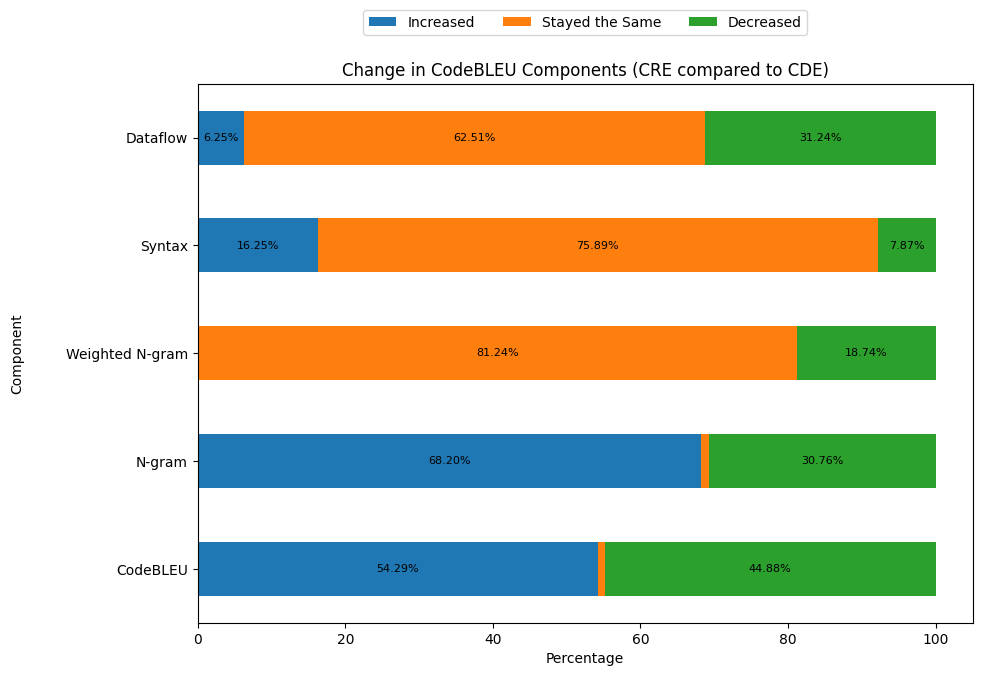

In [102]:
# Create a DataFrame for the results
df_results = pd.DataFrame(results_control, index=['Increased', 'Stayed the Same', 'Decreased']).drop(columns=['indices'])
df_results_copy = df_results.copy()

df_results_copy.columns = ['CodeBLEU', 'N-gram', 'Weighted N-gram', 'Syntax', 'Dataflow']

# Transpose the DataFrame
df_results_copy = df_results_copy.T

# Plot the results
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the DataFrame as a horizontal bar chart
bars = df_results_copy.plot(kind='barh', stacked=True, ax=ax)

# Add labels and title
ax.set_xlabel('Percentage')
ax.set_ylabel('Component', labelpad=30)  # Increase the space between the y-axis labels and the plot
ax.set_title('Percentage of CodeBLEU components that increased, stayed the same, and decreased')

# Move the legend up
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

# Add percentages inside each stack with a condition to avoid overflow
for container in bars.containers:
    labels = [f'{v.get_width():.2f}%' if v.get_width() > 5 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=8)

# Display the plot
plt.title('Change in CodeBLEU Components (CRE compared to CDE)')
plt.show()

In [79]:
# Initialize an empty list to store the results
model_results = []

# Group the dataframes by the 'model' column
grouped_cre = df_cre_results.groupby('model')
grouped_cde = df_cde_results.groupby('model')

# Iterate over each model group
for model_name, group_cre in grouped_cre:
    group_cde = grouped_cde.get_group(model_name)
    
    # Ensure the groups are aligned by index
    group_cre = group_cre.sort_values(by='index').reset_index(drop=True)
    group_cde = group_cde.sort_values(by='index').reset_index(drop=True)
    
    # Compute the improvements
    results_cre = count_improvements_results(group_cre, group_cde)
    # Compute the improvements for VRE
    group_vre = df_vre_results[df_vre_results['model'] == model_name]
    group_vde = df_vde_results[df_vde_results['model'] == model_name]
    
    # Ensure the groups are aligned by index
    group_vre = group_vre.sort_values(by='index').reset_index(drop=True)
    group_vde = group_vde.sort_values(by='index').reset_index(drop=True)
    
    results_vre = count_improvements_results(group_vre, group_vde)
    
    # Flatten the results dictionary and add the model name
    flattened_results = {
        'model': model_name,
        'code_bleu_increased_cre': round(results_cre['code_bleu'][0], 2),
        'code_bleu_same_cre': round(results_cre['code_bleu'][1], 2),
        'code_bleu_decreased_cre': round(results_cre['code_bleu'][2], 2),
        'blue_increased_cre': round(results_cre['ngram_match_score'][0], 2),
        'blue_same_cre': round(results_cre['ngram_match_score'][1], 2),
        'blue_decrease_cre': round(results_cre['ngram_match_score'][2], 2),
        'code_bleu_increased_vre': round(results_vre['code_bleu'][0], 2),
        'code_bleu_same_vre': round(results_vre['code_bleu'][1], 2),
        'code_bleu_decreased_vre': round(results_vre['code_bleu'][2], 2),
        'blue_increased_vre': round(results_vre['ngram_match_score'][0], 2),
        'blue_same_vre': round(results_vre['ngram_match_score'][1], 2),
        'blue_decrease_vre': round(results_vre['ngram_match_score'][2], 2)
    }
    
    # Append the flattened results to the list
    model_results.append(flattened_results)

# Convert the list of results into a DataFrame
df_model_results = pd.DataFrame(model_results)

# Round the results to two significant digits before applying the lambda function
df_model_results['code_bleu_increased_cre'] = df_model_results['code_bleu_increased_cre'].round(2)
df_model_results['blue_increased_cre'] = df_model_results['blue_increased_cre'].round(2)
df_model_results['code_bleu_increased_vre'] = df_model_results['code_bleu_increased_vre'].round(2)
df_model_results['blue_increased_vre'] = df_model_results['blue_increased_vre'].round(2)

# Add a new column 'code_bleu_trend_cre' based on the 'code_bleu_increased_cre' value
df_model_results['code_bleu_trend_cre'] = df_model_results['code_bleu_increased_cre']

# Add a new column 'blue_trend_cre' based on the 'blue_increased_cre' value
df_model_results['blue_trend_cre'] = df_model_results['blue_increased_cre']

# Add a new column 'code_bleu_trend_vre' based on the 'code_bleu_increased_vre' value
df_model_results['code_bleu_trend_vre'] = df_model_results['code_bleu_increased_vre']

# Add a new column 'blue_trend_vre' based on the 'blue_increased_vre' value
df_model_results['blue_trend_vre'] = df_model_results['blue_increased_vre']

# Select only the trend columns
df_trends = df_model_results[['model', 'code_bleu_trend_cre', 'blue_trend_cre', 'code_bleu_trend_vre', 'blue_trend_vre']]

# Display the updated DataFrame
df_trends
# Calculate the average for each column
average_row = df_trends.mean(numeric_only=True)

# Add a new row with the averages
df_trends.loc['Average'] = average_row

# Display the updated DataFrame
df_trends

/tmp/ipykernel_2205060/4232786225.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trends.loc['Average'] = average_row


,model,code_bleu_trend_cre,blue_trend_cre,code_bleu_trend_vre,blue_trend_vre
0,CodeLlama-13b-Instruct-hf,52.28,59.08,80.77,38.46
1,CodeLlama-34b-Instruct-hf,40.84,80.01,52.48,79.16
2,CodeLlama-7b-Instruct-hf,54.18,64.09,61.00,69.71
3,Magicoder-CL-7B,66.90,62.37,75.39,65.86
4,Magicoder-S-CL-7B,67.13,62.41,54.32,79.41
5,WizardCoder-1B-V1.0,45.18,75.20,55.84,76.38
6,WizardCoder-3B-V1.0,52.62,75.68,43.09,83.68
7,WizardCoder-Python-13B-V1.0,53.30,65.15,44.89,81.14
8,WizardCoder-Python-34B-V1.0,46.16,76.26,54.75,74.79
9,WizardCoder-Python-7B-V1.0,65.31,61.08,51.99,72.26


In [74]:
print(average_row)

Series([], dtype: float64)


In [47]:
# Initialize an empty list to store the results
model_results_vre = []

# Group the dataframes by the 'model' column
grouped_vre = df_vre_results.groupby('model')
grouped_vde = df_vde_results.groupby('model')

# Iterate over each model group
for model_name, group_vre in grouped_vre:
    group_vde = grouped_vde.get_group(model_name)
    
    # Ensure the groups are aligned by index
    group_vre = group_vre.sort_values(by='index').reset_index(drop=True)
    group_vde = group_vde.sort_values(by='index').reset_index(drop=True)
    
    # Compute the improvements
    results = count_improvements_results(group_vre, group_vde)
    
    # Flatten the results dictionary and add the model name
    flattened_results = {
        'model': model_name,
        'code_bleu_increased': results['code_bleu'][0],
        'code_bleu_same': results['code_bleu'][1],
        'code_bleu_decreased': results['code_bleu'][2],
        'blue_increased': results['ngram_match_score'][0],
        'blue_same': results['ngram_match_score'][1],
        'blue_decrease': results['ngram_match_score'][2]
    }
    
    # Append the flattened results to the list
    model_results_vre.append(flattened_results)

# Convert the list of results into a DataFrame
df_model_results_vre = pd.DataFrame(model_results_vre)

# Add a new column 'code_bleu_trend' based on the 'code_bleu_increased' value
df_model_results_vre['code_bleu_trend'] = df_model_results_vre['code_bleu_increased'].apply(lambda x: '↑' if x > 50 else '↓')

# Add a new column 'blue_trend' based on the 'blue_increased' value
df_model_results_vre['blue_trend'] = df_model_results_vre['blue_increased'].apply(lambda x: '↑' if x > 50 else '↓')

# Display the updated DataFrame
df_model_results_vre

# Display the DataFrame
df_model_results_vre

,model,code_bleu_increased,code_bleu_same,code_bleu_decreased,blue_increased,blue_same,blue_decrease,code_bleu_trend,blue_trend
0,CodeLlama-13b-Instruct-hf,80.769231,0.000000,19.230769,38.461538,0.000000,61.538462,↑,↓
1,CodeLlama-34b-Instruct-hf,52.475928,0.481431,47.042641,79.160935,1.169188,19.669876,↑,↑
2,CodeLlama-7b-Instruct-hf,60.995851,0.829876,38.174274,69.709544,1.659751,28.630705,↑,↑
3,Magicoder-CL-7B,75.387058,0.992457,23.620484,65.859468,1.071854,33.068678,↑,↑
4,Magicoder-S-CL-7B,54.315558,0.109951,45.574491,79.411765,0.659703,19.928532,↑,↑
5,WizardCoder-1B-V1.0,55.839279,0.563275,43.597446,76.380023,0.976342,22.643635,↑,↑
6,WizardCoder-3B-V1.0,43.086817,0.281350,56.631833,83.681672,0.884244,15.434084,↓,↑
7,WizardCoder-Python-13B-V1.0,44.893293,0.152439,54.954268,81.135671,0.724085,18.140244,↓,↑
8,WizardCoder-Python-34B-V1.0,54.750706,0.564440,44.684854,74.788335,0.564440,24.647225,↑,↑
9,WizardCoder-Python-7B-V1.0,51.986532,1.010101,47.003367,72.255892,1.212121,26.531987,↑,↑


In [49]:
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats import mannwhitneyu
import cliffs_delta

pd.options.display.float_format = '{:.2f}'.format

df_vre_results_avg = df_vre_results.groupby('model')[['code_bleu', 'ngram_match_score']].mean().reset_index()
df_vde_results_avg = df_vde_results.groupby('model')[['code_bleu', 'ngram_match_score']].mean().reset_index()

# Rename ngram_match_score to bleu
df_vre_results_avg.rename(columns={'ngram_match_score': 'bleu'}, inplace=True)
df_vde_results_avg.rename(columns={'ngram_match_score': 'bleu'}, inplace=True)

# Merge the two dataframes on the 'model' column
df_avg_results = pd.merge(df_vre_results_avg, df_vde_results_avg, on='model', suffixes=('_vre', '_vde'))

# Reorganize columns for easier comparison
df_avg_results = df_avg_results[['model', 'code_bleu_vre', 'code_bleu_vde', 'bleu_vre', 'bleu_vde']]

# Find the experiment with the maximum code_bleu value for each model
# df_avg_results['max_code_bleu'] = np.where(df_avg_results['code_bleu_vre'] >= df_avg_results['code_bleu_vde'], 'VRE', 'VDE')
# df_avg_results['max_bleu'] = np.where(df_avg_results['bleu_vre'] >= df_avg_results['bleu_vde'], 'VRE', 'VDE')

df_avg_results = df_avg_results.round(2)
# Initialize lists to store test results
p_values = []
cliffs_deltas = []
significances = []

# Perform Mann-Whitney U test and Cliff's Delta for each model
for model in df_vre_results['model'].unique():
    vre_scores = df_vre_results[(df_vre_results['model'] == model)]['code_bleu']
    vde_scores = df_vde_results[(df_vde_results['model'] == model)]['code_bleu']
    
    # Perform Mann-Whitney U test for code_bleu
    u_stat, p_value = mannwhitneyu(vre_scores, vde_scores, alternative='two-sided')
    
    # Calculate effect size using Cliff's Delta for code_bleu
    delta, res = cliffs_delta.cliffs_delta(vre_scores, vde_scores)
    
    # Determine significance for code_bleu
    significance = "Yes" if p_value < 0.05 else "No"
    
    # Append results to lists for code_bleu
    p_values.append(p_value)
    cliffs_deltas.append(delta)
    significances.append(significance)

# Add test results for code_bleu to the DataFrame
#df_avg_results['p_value_code_bleu'] = p_values
df_avg_results['cliffs_delta_code_bleu'] = cliffs_deltas
df_avg_results['significance_code_bleu'] = significances

# Reset lists for blue
p_values = []
cliffs_deltas = []
significances = []

# Perform Mann-Whitney U test and Cliff's Delta for each model for blue
for model in df_vre_results['model'].unique():
    vre_scores = df_vre_results[(df_vre_results['model'] == model)]['ngram_match_score']
    vde_scores = df_vde_results[(df_vde_results['model'] == model)]['ngram_match_score']
    
    # Perform Mann-Whitney U test for blue
    u_stat, p_value = mannwhitneyu(vre_scores, vde_scores, alternative='two-sided')
    
    # Calculate effect size using Cliff's Delta for blue
    delta, res = cliffs_delta.cliffs_delta(vre_scores, vde_scores)
    
    # Determine significance for blue
    significance = "Yes" if p_value < 0.05 else "No"
    
    # Append results to lists for blue
    p_values.append(p_value)
    cliffs_deltas.append(delta)
    significances.append(significance)

# Add test results for blue to the DataFrame
#df_avg_results['p_value_blue'] = p_values
df_avg_results['cliffs_delta_blue'] = cliffs_deltas
df_avg_results['significance_blue'] = significances

df_avg_results


,model,code_bleu_vre,code_bleu_vde,bleu_vre,bleu_vde,cliffs_delta_code_bleu,significance_code_bleu,cliffs_delta_blue,significance_blue
0,CodeLlama-13b-Instruct-hf,0.26,0.12,0.11,0.10,0.52,Yes,0.01,No
1,CodeLlama-34b-Instruct-hf,0.29,0.28,0.09,0.06,0.02,No,0.14,Yes
2,CodeLlama-7b-Instruct-hf,0.29,0.26,0.11,0.08,0.10,Yes,0.16,Yes
3,Magicoder-CL-7B,0.31,0.27,0.11,0.10,0.14,Yes,0.02,No
4,Magicoder-S-CL-7B,0.30,0.27,0.10,0.06,0.09,Yes,0.18,Yes
5,WizardCoder-1B-V1.0,0.29,0.29,0.10,0.07,-0.03,No,0.15,Yes
6,WizardCoder-3B-V1.0,0.30,0.31,0.10,0.05,-0.06,Yes,0.28,Yes
7,WizardCoder-Python-13B-V1.0,0.31,0.30,0.11,0.05,-0.03,No,0.26,Yes
8,WizardCoder-Python-34B-V1.0,0.32,0.30,0.12,0.07,0.06,Yes,0.20,Yes
9,WizardCoder-Python-7B-V1.0,0.29,0.30,0.08,0.07,-0.05,Yes,0.12,Yes


In [50]:
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats import mannwhitneyu
import cliffs_delta

pd.options.display.float_format = '{:.2f}'.format

df_cre_results_avg = df_cre_results.groupby('model')[['code_bleu', 'ngram_match_score']].mean().reset_index()
df_cde_results_avg = df_cde_results.groupby('model')[['code_bleu', 'ngram_match_score']].mean().reset_index()

# Rename ngram_match_score to bleu
df_cre_results_avg.rename(columns={'ngram_match_score': 'bleu'}, inplace=True)
df_cde_results_avg.rename(columns={'ngram_match_score': 'bleu'}, inplace=True)

# Merge the two dataframes on the 'model' column
df_avg_results = pd.merge(df_cre_results_avg, df_cde_results_avg, on='model', suffixes=('_cre', '_cde'))

# Reorganize columns for easier comparison
df_avg_results = df_avg_results[['model', 'code_bleu_cre', 'code_bleu_cde', 'bleu_cre', 'bleu_cde']]

# Find the experiment with the maximum code_bleu value for each model
# df_avg_results['max_code_bleu'] = np.where(df_avg_results['code_bleu_cre'] >= df_avg_results['code_bleu_cde'], 'CRE', 'CDE')
# df_avg_results['max_bleu'] = np.where(df_avg_results['bleu_cre'] >= df_avg_results['bleu_cde'], 'CRE', 'CDE')

df_avg_results = df_avg_results.round(2)
# Initialize lists to store test results
p_values = []
cliffs_deltas = []
significances = []

# Perform Mann-Whitney U test and Cliff's Delta for each model
for model in df_vre_results['model'].unique():
    vre_scores = df_vre_results[(df_vre_results['model'] == model)]['code_bleu']
    vde_scores = df_vde_results[(df_vde_results['model'] == model)]['code_bleu']
    
    # Perform Mann-Whitney U test for code_bleu
    u_stat, p_value = mannwhitneyu(vre_scores, vde_scores, alternative='two-sided')
    
    # Calculate effect size using Cliff's Delta for code_bleu
    delta, res = cliffs_delta.cliffs_delta(vre_scores, vde_scores)
    
    # Determine significance for code_bleu
    significance = "significant" if p_value < 0.05 else "not significant"
    
    # Append results to lists for code_bleu
    p_values.append(p_value)
    cliffs_deltas.append(delta)
    significances.append(significance)

# Add test results for code_bleu to the DataFrame
#df_avg_results['p_value_code_bleu'] = p_values
df_avg_results['cliffs_delta_code_bleu'] = cliffs_deltas
df_avg_results['significance_code_bleu'] = significances

# Reset lists for blue
p_values = []
cliffs_deltas = []
significances = []

# Perform Mann-Whitney U test and Cliff's Delta for each model for blue
for model in df_vre_results['model'].unique():
    vre_scores = df_vre_results[(df_vre_results['model'] == model)]['ngram_match_score']
    vde_scores = df_vde_results[(df_vde_results['model'] == model)]['ngram_match_score']
    
    # Perform Mann-Whitney U test for blue
    u_stat, p_value = mannwhitneyu(vre_scores, vde_scores, alternative='two-sided')
    
    # Calculate effect size using Cliff's Delta for blue
    delta, res = cliffs_delta.cliffs_delta(vre_scores, vde_scores)
    
    # Determine significance for blue
    significance = "Yes" if p_value < 0.05 else "No"
    
    # Append results to lists for blue
    p_values.append(p_value)
    cliffs_deltas.append(delta)
    significances.append(significance)

# Add test results for blue to the DataFrame
#df_avg_results['p_value_blue'] = p_values
df_avg_results['cliffs_delta_blue'] = cliffs_deltas
df_avg_results['significance_blue'] = significances

df_avg_results


,model,code_bleu_cre,code_bleu_cde,bleu_cre,bleu_cde,cliffs_delta_code_bleu,significance_code_bleu,cliffs_delta_blue,significance_blue
0,CodeLlama-13b-Instruct-hf,0.30,0.30,0.11,0.11,0.52,significant,0.01,No
1,CodeLlama-34b-Instruct-hf,0.29,0.30,0.11,0.04,0.02,not significant,0.14,Yes
2,CodeLlama-7b-Instruct-hf,0.30,0.30,0.11,0.11,0.10,significant,0.16,Yes
3,Magicoder-CL-7B,0.30,0.30,0.10,0.10,0.14,significant,0.02,No
4,Magicoder-S-CL-7B,0.30,0.29,0.10,0.10,0.09,significant,0.18,Yes
5,WizardCoder-1B-V1.0,0.29,0.29,0.10,0.06,-0.03,not significant,0.15,Yes
6,WizardCoder-3B-V1.0,0.30,0.30,0.11,0.06,-0.06,significant,0.28,Yes
7,WizardCoder-Python-13B-V1.0,0.30,0.30,0.11,0.09,-0.03,not significant,0.26,Yes
8,WizardCoder-Python-34B-V1.0,0.31,0.31,0.12,0.07,0.06,significant,0.20,Yes
9,WizardCoder-Python-7B-V1.0,0.30,0.30,0.11,0.11,-0.05,significant,0.12,Yes


In [51]:
import random

results_control['indices']['less_dataflow']

random.seed(1)
sample = random.sample(results_control['indices']['less_dataflow'], 50)

In [52]:
import pandas as pd

# Join the dataframes on the "index" column
df_merged = pd.merge(df_vre_filtered, df_vde, on="index", suffixes=("_vre", "_vde"))

# Select the "new_tokens_from_inference_output" column
df_output = df_merged[["index", "proc_inference_output_vre", "proc_inference_output_vde"]]

df_less = df_output[df_output.index.isin(sample)]

# Export the dataframe to an Excel file
df_less.to_excel("output_dataflow.xlsx", index=False)

In [53]:
import random


random.seed(1)
sample_ngram = random.sample(results_control['indices']['less_weighted_ngram'], 50)

In [54]:
import pandas as pd

# Join the dataframes on the "index" column
df_merged = pd.merge(df_vre, df_vde, on="index", suffixes=("_vre", "_vde"))

# Select the "new_tokens_from_inference_output" column
df_output = df_merged[["index", "proc_inference_output_vre", "proc_inference_output_vde"]]

df_less = df_output[df_output.index.isin(sample_ngram)]

# Export the dataframe to an Excel file
df_less.to_excel("output_ngram.xlsx", index=False)

In [57]:
from scipy.stats import shapiro

# Perform the Shapiro-Wilk test
stat, p_value = shapiro(df_cde_results['code_bleu'])

# Check if the p-value is greater than 0.05
is_normal = p_value > 0.05

# Report the result
print("Yes" if is_normal else "No")

No


/root/.envs/envs/expandclient/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 35402.
  res = hypotest_fun_out(*samples, **kwds)


In [58]:
def get_top_code_bleu_differences(df_cre_results, df_cde_results, top_n=2):
    """
    Calculate the top N examples with the largest positive and negative differences in CodeBLEU scores between CRE and CDE.

    Parameters:
    df_cre_results (pd.DataFrame): DataFrame containing CRE results.
    df_cde_results (pd.DataFrame): DataFrame containing CDE results.
    top_n (int): Number of top examples to retrieve for both positive and negative differences.

    Returns:
    pd.DataFrame: DataFrame containing the top N examples with the largest positive and negative differences.
    """
    # Calculate the difference in CodeBLEU scores between CRE and CDE
    df_cre_results.sort_values(by='index', ascending=False, inplace=True)
    df_cde_results.sort_values(by='index', ascending=False, inplace=True)

    df_cre_results['code_bleu_diff'] = df_cre_results['code_bleu'] - df_cde_results['code_bleu']

    # Sort the DataFrame by the absolute difference in descending order
    df_cre_results_sorted = df_cre_results.sort_values(by='code_bleu_diff', ascending=False)

    # Get the top N examples with the largest positive difference
    top_positive_diff = df_cre_results_sorted.head(top_n)

    # Get the top N examples with the largest negative difference
    top_negative_diff = df_cre_results_sorted.tail(top_n)

    # Combine the results
    top_examples = pd.concat([top_positive_diff, top_negative_diff])

    return top_examples

In [59]:
# Example usage
top_2_examples_control = get_top_code_bleu_differences(df_cre_results, df_cde_results, top_n=20)
top_2_examples_vanilla = get_top_code_bleu_differences(df_vre_results, df_vde_results, top_n=20)

In [60]:
def display_code_bleu_examples(df_cde, df_cre, df_cde_results, df_cre_results, examples):
    """
    Display the input code and the corresponding CodeBLEU scores for the given examples.

    Parameters:
    df_cde (pd.DataFrame): DataFrame containing the CDE results.
    df_cre (pd.DataFrame): DataFrame containing the CRE results.
    df_cde_results (pd.DataFrame): DataFrame containing the CDE scores.
    df_cre_results (pd.DataFrame): DataFrame containing the CRE scores.
    examples (pd.DataFrame): DataFrame containing the examples to display.

    Returns:
    None
    """
    for index, row in examples.iterrows():
        print(f"Index: {row['index']}")
        example_before = df_cde.loc[df_cde['index'] == row['index'], 'proc_inference_output'].values[0]
        example_after = df_cre.loc[df_cre['index'] == row['index'], 'proc_inference_output'].values[0]

        bleu_before = round(df_cde_results.loc[df_cde_results['index'] == row['index'], 'ngram_match_score'].values[0], 2)
        bleu_after = round(df_cre_results.loc[df_cre_results['index'] == row['index'], 'ngram_match_score'].values[0], 2)

        cb_before = round(df_cde_results.loc[df_cde_results['index'] == row['index'], 'code_bleu'].values[0], 2)
        cb_after = round(df_cre_results.loc[df_cre_results['index'] == row['index'], 'code_bleu'].values[0], 2)

        print(f"CodeBLEU: {cb_before}")
        print(f"BLEU: {bleu_before}")
        print(f"CDE Output Code:\n{example_before}")

        print("\nAfter\n")

        print(f"CodeBLEU: {cb_after}")
        print(f"BLEU: {bleu_after}")
        print(f"CRE Output Code:\n{example_after}")

        print("\n" + "="*80 + "\n")